<a href="https://colab.research.google.com/github/THECODEDEMOGORGON/TS_DL_workshop/blob/main/3_NBEATS_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Для начала установим библиотеку pytorch-forecasting  и импортируем необходимые модули.


In [ ]:
!pip install pytorch-forecasting

# Clearing outputs in Jupyter Notebook
from IPython.display import clear_output
clear_output()

# Checking if the package is installed correctly
try:
    import pytorch_forecasting
    print("pytorch-forecasting is installed successfully.")
except ImportError:
    print("Failed to import pytorch-forecasting.")

pytorch-forecasting is installed successfully.


In [ ]:
import warnings
warnings.filterwarnings('ignore')
import random

#utils
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder


import torch
from torchmetrics.functional import r2_score

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
from lightning.pytorch.tuner import Tuner


from pytorch_forecasting import Baseline, DeepAR, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import RMSE, MAE, SMAPE, MultivariateNormalDistributionLoss
from pytorch_lightning.loggers import TensorBoardLogger


In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cuda


In [ ]:
def fix_random_seeds(seed=42):
    random.seed(seed)

    np.random.seed(seed)

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    pl.seed_everything(42)

fix_random_seeds()


INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Скачиваем данные:

In [ ]:
!wget https://media.githubusercontent.com/media/THECODEDEMOGORGON/TS_DL_workshop/main/data/full_data_sum.csv


--2023-10-16 20:54:12--  https://media.githubusercontent.com/media/THECODEDEMOGORGON/TS_DL_workshop/main/data/full_data_sum.csv
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344159591 (328M) [text/plain]
Saving to: ‘full_data_sum.csv’

full_data_sum.csv   100%[===================>] 328.22M   203MB/s    in 1.6s    

2023-10-16 20:54:24 (203 MB/s) - ‘full_data_sum.csv’ saved [344159591/344159591]



### 1. Импорт данных, небольшая предобработка
Для начала необходимо загрузить наш датасет и подготовить его к обучению модели. Также выполним небольшую фильтрацию данных, чтобы тратить меньше вычислительных ресурсов и быстрее выполнять эксперименты.

In [ ]:
%%time
df = pd.read_csv('./full_data_sum.csv')

CPU times: user 3.4 s, sys: 290 ms, total: 3.69 s
Wall time: 3.73 s


In [ ]:
# Предобработаем даты к удобному формату
df['date'] = pd.to_datetime(df['date'])
df['dt'] = pd.to_datetime(df.date) + df.hour.astype('timedelta64[h]')

# Для создания датасета нужно перейти от действительных значений времени к временным шагам
dates_transformer = LabelEncoder()
df['time_idx'] = dates_transformer.fit_transform(df.dt)
df['time_idx'] += 1

# Категориальные переменные должны быть в строковом типе
df['square_id'] = df['square_id'].astype(str)

Разделим выборку на обучение, валидацию, тест и зафиксируем шаги на которых заканчиваюстя обучающая и валидационная выборки

In [ ]:
dates = sorted(df.date.unique())
train_dates = dates[:49]
val_dates = dates[49:-1]
test_dates = dates[-1:]

train = df[df.date.isin(train_dates)]
val = df[df.date.isin(val_dates)]
test = df[df.date.isin(test_dates)]

train_cutoff = train['time_idx'].max()
validation_cutoff = test['time_idx'].max() - 25

В датасете большое количетсов временных рядов, которые очень сильно коррелируют между собой. Чтобы не тратить лишние ресурсы, возьмем только те станции, которые слабо коррелируют.

In [ ]:
# Заранее отобранные станции с низкой корреляцией
to_select = ['6974', '6554', '8966', '7445', '9361', '5557', '8847', '6875', '3862', '3527', '6274', '7155', '8087', '6071', '5445', '6745', '9986', '4349', '4972', '3234', '8045', '8380', '9877', '4639', '7987', '4657', '9398', '6077', '4478', '1684', '3958', '3258', '3554', '6754', '8176', '5473', '6846', '8502', '4144', '2247', '4664', '3957', '4973', '6472', '8046', '8242', '2145', '9778', '7552', '9869', '8958', '7055', '6836', '5451', '4040', '3532', '8891', '8757', '7167', '9150', '6467', '9474', '7154', '4345', '8558', '3928', '5443', '9785', '7424', '6664', '6546', '4830', '2654', '5245', '4128', '5368', '5447', '48', '7161', '8152', '4446', '4341', '4667', '5646', '7271', '6766', '6250', '6662', '7173', '7769', '6050', '4061', '8273', '4367', '3755', '3334', '8561', '4578', '3462', '8311', '7085', '3966', '3551', '6473', '8464', '8283', '8247', '7672', '8148', '4464', '7786', '4563', '3945', '6252', '4874', '6466', '5047', '3929', '8673', '6465', '5649', '7562', '3674', '8534', '3558', '7722', '4550', '8056', '3353', '7389', '5344', '4047', '6470', '3967', '6053', '4279', '8332', '6854', '7226', '8854', '6852', '3233', '6054', '7144', '4658', '7980', '6270', '5848', '6585', '7306', '5457', '7468', '6645', '5145', '6055', '5357', '4343', '4029', '3118', '3553', '4058', '6052', '4129', '3836', '5851', '3868', '4362', '6953', '6451', '4443', '3360', '4444', '5544', '4351', '9483', '9684', '6775', '3659', '4669', '7822', '851', '4642', '7341', '8776', '4452', '5847', '4056', '2960', '5957', '3632', '4876', '4350', '6444', '3759', '6447', '7754', '7240', '8286', '6972', '8177', '3863', '8459', '4742', '5636', '3954', '8278', '6297', '6461', '6869', '3871', '7073', '9770', '6695', '7375', '8011', '6647', '7143', '7753', '7540', '6833', '8885', '8934', '4889', '1150', '4158', '4526', '4378', '9598', '8856', '5669', '4354', '3655', '6961', '4748', '1147', '8004', '3763', '8274', '1349', '8562', '6976', '9155', '8751', '5865', '7172', '6648', '4826', '3748', '8791', '4948', '4542', '3285', '4428', '4951', '5437', '7684', '7354', '6355', '5551', '4147', '7163', '7156', '8744', '4057', '7724', '3960', '6459', '4327', '9143', '4777', '5458', '3255', '1555', '4743', '5953', '4066', '7324', '4851', '6154', '4666', '6769', '5450', '7273', '7075', '4678', '8746', '5755', '4453', '8013', '7551', '3432', '5947', '7046', '4871', '3661', '3854', '3767', '8374', '5948', '7556', '4852', '3845', '6663', '4243', '8688', '9351', '6260', '6371', '4027', '4565', '5543', '3962', '3828', '4344', '5372', '7256', '5977', '8049', '6877', '4726', '6572', '8441', '5550', '4379', '6966', '8410', '7305', '4143', '8051', '8833', '5741', '3427', '8085', '7453', '7353', '8435', '6872', '5273', '6756', '4068', '3347', '7852', '5750', '6862', '6046', '5653', '4276', '5753', '7813', '9266', '5146', '8835', '8271', '3671', '6150', '8071', '6671', '3765', '3654', '6152', '7065', '8635', '6153', '3733', '7265', '7064', '5028', '6971', '3970', '4733', '6151', '4228', '6533', '8312', '8756', '3548', '7623', '6372', '4553', '3959', '3673', '4226', '7342', '6755', '6771', '6367', '8047', '6853']

df = df[df.square_id.isin(to_select)]
train = train[train.square_id.isin(to_select)]
val = val[val.square_id.isin(to_select)]
test = test[test.square_id.isin(to_select)]

### 2. Создание TimeSeriesDataSet, DataLoader
Здесь мы подготовленные данные подаем в класс TimeSeriesDataSet, чтобы далее сделать корректный Dataloader, на котором сможем обучать модель и делать прогнозы.

In [ ]:
# Инициализируем датасеты

max_encoder_length = 60
max_prediction_length = 24


context_length = max_encoder_length
prediction_length = max_prediction_length

training = TimeSeriesDataSet(
    train,
    time_idx="time_idx",
    target="internet",
    categorical_encoders={"square_id": NaNLabelEncoder().fit(train.square_id)},
    group_ids=["square_id"],
    time_varying_unknown_reals=["internet"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    allow_missing_timesteps=False
)

validation = TimeSeriesDataSet.from_dataset(training,
                                            df,
                                            min_prediction_idx=train_cutoff + 1)

test = TimeSeriesDataSet.from_dataset(training,
                                      df,
                                      min_prediction_idx=validation_cutoff + 1,
                                      predict_mode=True)

Создаем dataloader'.
Обратите внимание, что все временные ряды были нарезаны на кусочки длиной max_encoder_length и max_prediction_length, и уже потом объединены в батчи.

Для каждого элемента батча у нас есть:
- вектор значений временного ряда, который подается на вход декодеру (encoder_target)
- вектор категориальных фичей (encoder_cat)
- длина входа (encoder_lenghts)
- вектор непрерывных фичей (encoder_cont)

*И все то же самое есть для выхода с приставкой 'decoder_'*

In [ ]:
batch_size = 128
train_dataloader = training.to_dataloader(
    train=True,
    batch_size=batch_size,
    num_workers=4,
    drop_last=True,
    batch_sampler="synchronized"
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=4, batch_sampler="synchronized"
)

# Выведем содержимое батча из датасета
x, y = next(iter(val_dataloader))
for key, value in x.items():
    print(f"\t{key} = {value.size()}")

	encoder_cat = torch.Size([128, 60, 0])
	encoder_cont = torch.Size([128, 60, 1])
	encoder_target = torch.Size([128, 60])
	encoder_lengths = torch.Size([128])
	decoder_cat = torch.Size([128, 24, 0])
	decoder_cont = torch.Size([128, 24, 1])
	decoder_target = torch.Size([128, 24])
	decoder_lengths = torch.Size([128])
	decoder_time_idx = torch.Size([128, 24])
	groups = torch.Size([128, 1])
	target_scale = torch.Size([128, 2])


Следующую ячейку можно использовать, чтобы еще сильнее сократить объем датасета. Здесь из наших станций берутся только случайные 150.
Вы можете использовать полный датасет, просто код будет работать дольше.

In [ ]:
%%time

# Сделаем еще один набор данных для быстрого обучения и валидации, куда возьмем лишь часть временных рядов
# При желании можно воспользоваться и полными датасетами

random_bs = np.random.choice(df.square_id.unique(), 150)


train_sample = TimeSeriesDataSet.from_dataset(training, train[train.square_id.isin(random_bs)])
validation_sample = TimeSeriesDataSet.from_dataset(training, val[val.square_id.isin(random_bs)], min_prediction_idx=train_cutoff + 1)


train_subset_loader = train_sample.to_dataloader(
    train=True,
    batch_size=batch_size,
    num_workers=4,
    drop_last=True,
    batch_sampler="synchronized")

val_subset_loader = validation_sample.to_dataloader(
    train=False, batch_size=batch_size, num_workers=4, batch_sampler="synchronized"
)

# Проверим, что данные внутри такие же как и в полной валидации
x, y = next(iter(val_subset_loader))
for key, value in x.items():
    print(f"\t{key} = {value.size()}")

	encoder_cat = torch.Size([123, 60, 0])
	encoder_cont = torch.Size([123, 60, 1])
	encoder_target = torch.Size([123, 60])
	encoder_lengths = torch.Size([123])
	decoder_cat = torch.Size([123, 24, 0])
	decoder_cont = torch.Size([123, 24, 1])
	decoder_target = torch.Size([123, 24])
	decoder_lengths = torch.Size([123])
	decoder_time_idx = torch.Size([123, 24])
	groups = torch.Size([123, 1])
	target_scale = torch.Size([123, 2])
CPU times: user 864 ms, sys: 136 ms, total: 1 s
Wall time: 2.56 s


### 3. Расчет бейзлайна
Для оценки качества нашей сети нам нужно ее с чем-то сравнить, воспользуемся бейзлайном в библиотеке torch forecasting.
В случае torch forecasting, Baseline - это модель, которая в качестве предсказание использует последнее известное значение временного ряда

In [ ]:
%%time
# Запишем ответы из валидации в один тензор, чтобы быстрее считать метрики
val_answers = torch.cat([y[0] for x, y in iter(val_subset_loader)]).to(DEVICE)

CPU times: user 978 ms, sys: 443 ms, total: 1.42 s
Wall time: 33.7 s


In [ ]:
%%time
# Запустим бейзлайн на валидационной выборке, а качество такого прогноза посмотрим чуть позже
baseline_predictions = Baseline().predict(val_subset_loader,
                                          trainer_kwargs=dict(accelerator=DEVICE),
                                          return_y=False)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


CPU times: user 5.09 s, sys: 796 ms, total: 5.89 s
Wall time: 30 s


### 4. Обучение сети
Здесь с помощью фреймворка lightning мы подберем оптимальный learning_rate, зададим гиперпараметры и запустим обучение сети.

In [ ]:
pl.seed_everything(42)

trainer = pl.Trainer(accelerator=DEVICE, gradient_clip_val=1e-1)
net = NBeats.from_dataset(training,
                          learning_rate=3e-2,
                          weight_decay=1e-2,
                          widths=[64, 256],
                          backcast_loss_ratio=0.1)

INFO: Global seed set to 42
INFO:lightning.fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: LR finder stopped early after 92 steps due to diverging loss.
INFO:lightning.pytorch.tuner.lr_finder:LR finder stopped early after 92 steps due to diverging loss.
INFO: Learning rate set to 0.003467368504525315
INFO:lightning.pytorch.tuner.lr_finder:Learning rate set to 0.003467368504525315
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_71025985-6ec2-49c6-975c-864c298cfd93.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_71025985-6ec2-49c6-975c-864c298cfd93.ckpt


suggested learning rate: 0.003467368504525315


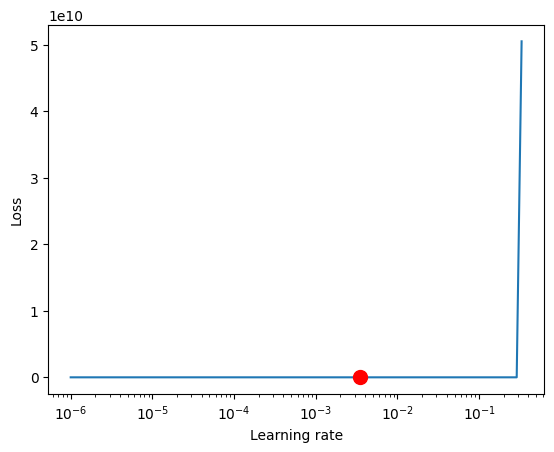

In [ ]:
res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_subset_loader,
    val_dataloaders=val_subset_loader,
    min_lr=1e-6,
    max_lr=1e0,
    early_stop_threshold=10,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

Запускаем обучение сети и логируем метрики

In [ ]:
%%time
logger = TensorBoardLogger('NBeats_base_Fit', name='NB_base_model')

early_stop_callback = EarlyStopping(monitor="val_loss",
                                    min_delta=1e-4,
                                    patience=10,
                                    verbose=False,
                                    mode="min")
trainer = pl.Trainer(
    max_epochs=3,
    accelerator=DEVICE,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    # limit_train_batches=200,
    limit_val_batches=200,
    enable_checkpointing=True,
    logger=logger
)

trainer.fit(
    net,
    train_dataloaders=train_subset_loader,
    val_dataloaders=val_subset_loader
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name            | Type       | Params
-----------------------------------------------
0 | loss            | MASE       | 0     
1 | logging_metrics | ModuleList | 0     
2 | net_blocks      | ModuleList | 497 K 
-----------------------------------------------
497 K     Trainable params
0         Non-trainable params
497 K     Total params
1.989     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name            | Type       | Params
-----------------------------------------------
0 | lo

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


CPU times: user 2min 13s, sys: 7.36 s, total: 2min 20s
Wall time: 8min 26s


In [ ]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

### 5. Валидация
Сеть обучена, пришло время оценить качество нашей модели.

In [ ]:
def evaluate(predictions, answers):
    rmse = RMSE()(predictions, answers).item()
    smape = SMAPE()(predictions, answers).item()
    mae = MAE()(predictions, answers).item()
    r2 = r2_score(predictions, answers).item()

    print(f"Evaluation Metrics:")
    print(f"RMSE: {rmse:.3f}")
    print(f"SMAPE: {smape:.3f}")
    print(f"MAE: {mae:.3f}")
    print(f"R-squared: {r2:.3f}")

In [ ]:
%%time
predictions = best_model.predict(val_subset_loader,
                                 trainer_kwargs=dict(accelerator=DEVICE), )


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


CPU times: user 3.53 s, sys: 550 ms, total: 4.08 s
Wall time: 26.3 s


In [ ]:
evaluate(predictions, val_answers)

Evaluation Metrics:
RMSE: 164.683
SMAPE: 0.139
MAE: 94.258
R-squared: 0.889


In [ ]:
evaluate(baseline_predictions, val_answers)

Evaluation Metrics:
RMSE: 350.233
SMAPE: 0.339
MAE: 229.037
R-squared: 0.497


NBEATS показывает результаты значительно лучше бейзлайна!

Попробуйте использовать другие параметры при обучении и выбить результат выше (скажу сразу, это возможно 😸). Также не забывайте, что можно поменять max_encoder_length.


### 6. Инференс на тестовой выборке

Для инференса создадим даталоадер, куда попадут только части временных рядов, необходимые для финального прогноза.


В случае реального прогнозирования, когда у нас нет заранее известных ответов, мы могли бы заполнить датасет на N шагов вперед нулями, и также выполнить предикт

In [ ]:
test_dataset = TimeSeriesDataSet.from_dataset(training,
                                      df,
                                      min_prediction_idx=validation_cutoff + 1,
                                      predict_mode=True)

test_loader = test_dataset.to_dataloader(
    train=False, batch_size=batch_size, num_workers=4, batch_sampler="synchronized"
)


In [ ]:
test_answers = torch.cat([y[0] for x, y in iter(test_loader)]).to('cpu')

In [ ]:
raw_predictions = net.predict(test_loader, mode="prediction", return_x=True)

test_preds = raw_predictions[0].to('cpu')
x = raw_predictions[1]['encoder_target'].to('cpu')

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
#Зафиксируем финальные метрики
evaluate(test_preds, test_answers)

Evaluation Metrics:
RMSE: 200.179
SMAPE: 0.226
MAE: 123.559
R-squared: 0.724


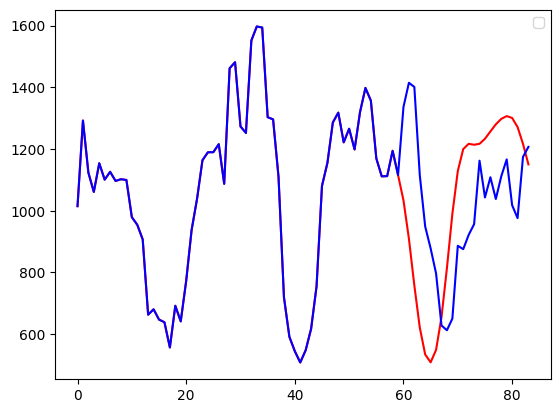

In [ ]:
# Можно визуализировать отдельные прогнозы
base_station_num = 60
plt.plot(np.concatenate([x[base_station_num], test_preds[base_station_num]]), color='red')
plt.plot(np.concatenate([x[base_station_num], test_answers[base_station_num]]), color='blue')
plt.legend()

Для модели NBEATS можно также выделить тренд и сезонность из данных

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


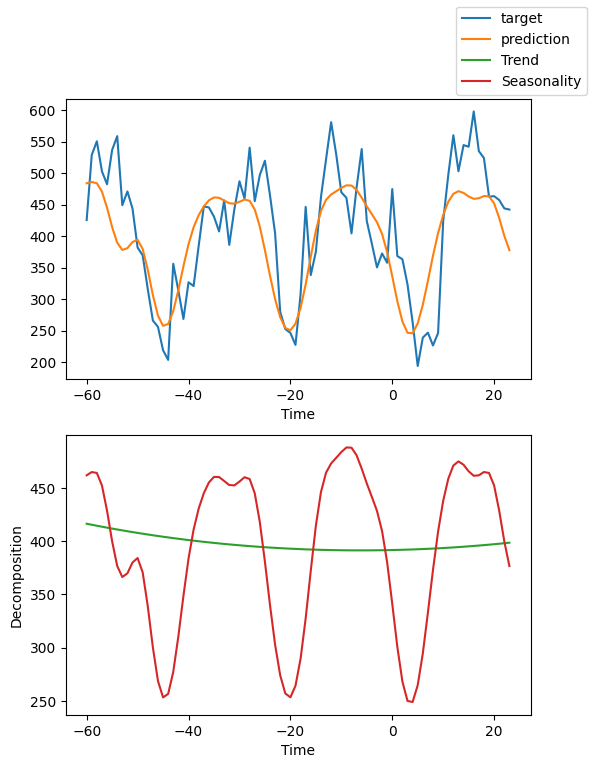

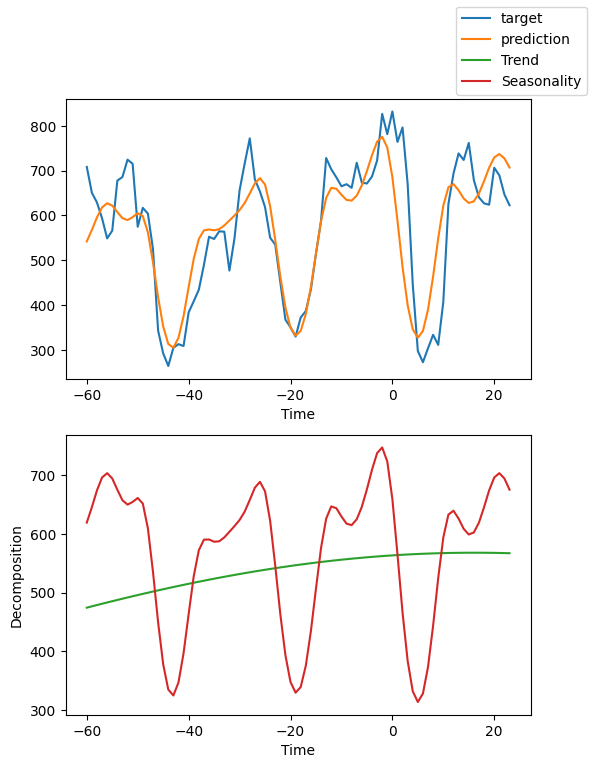

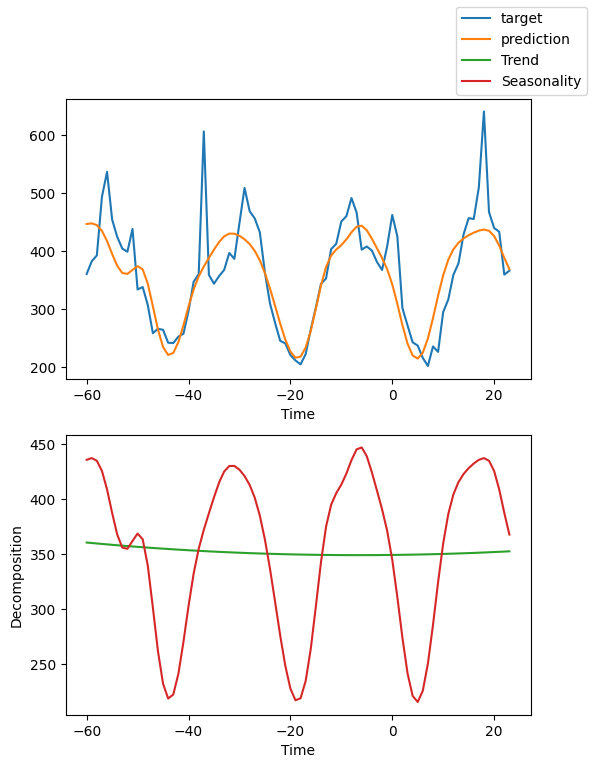

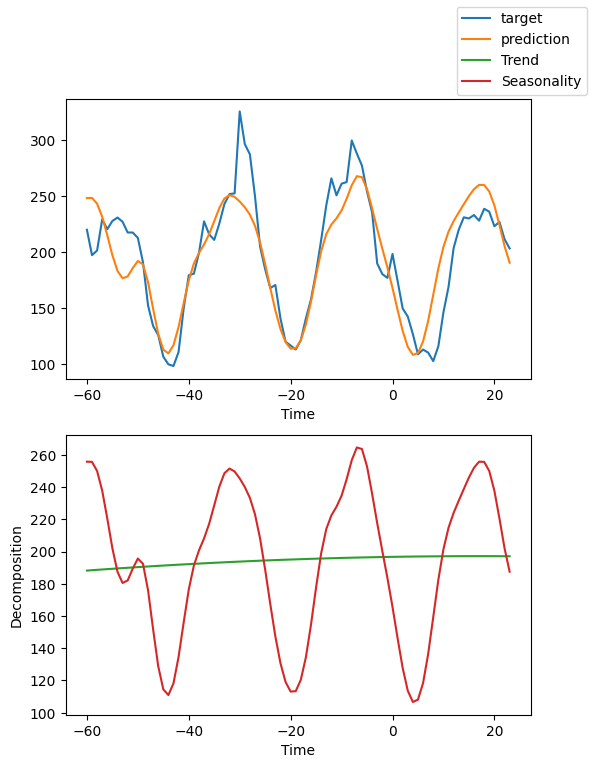

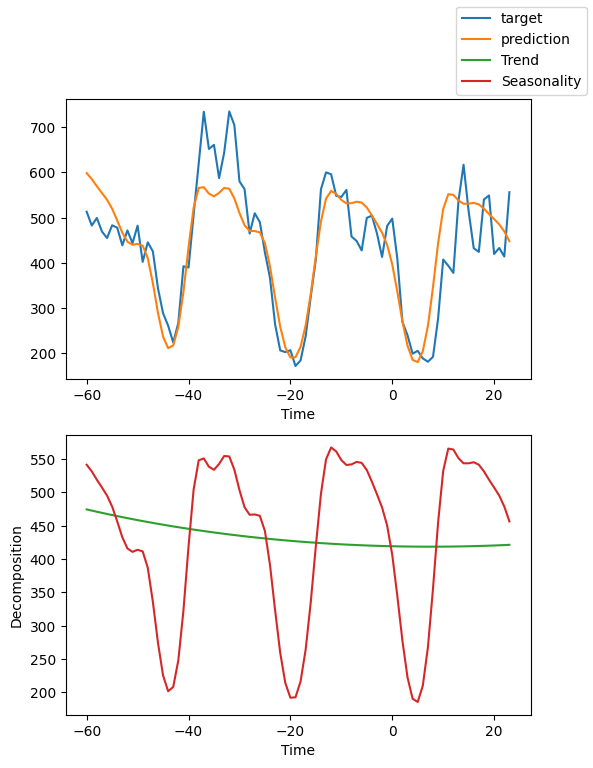

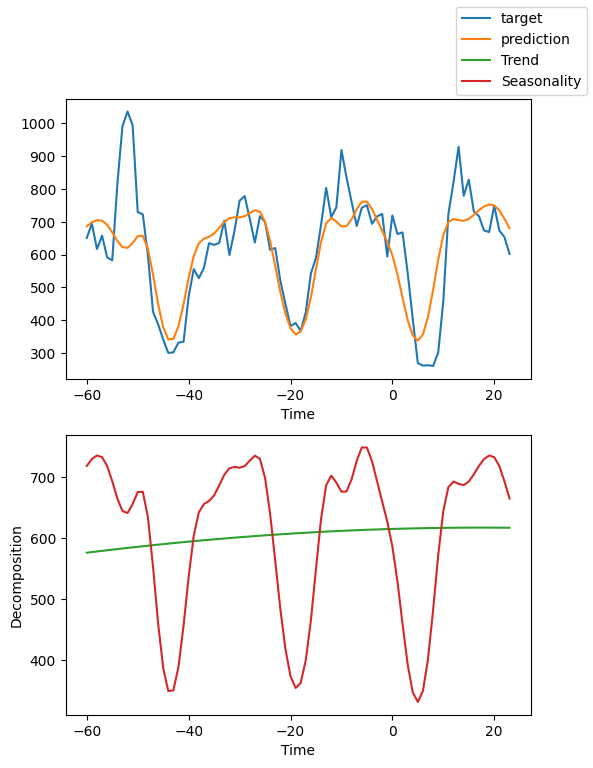

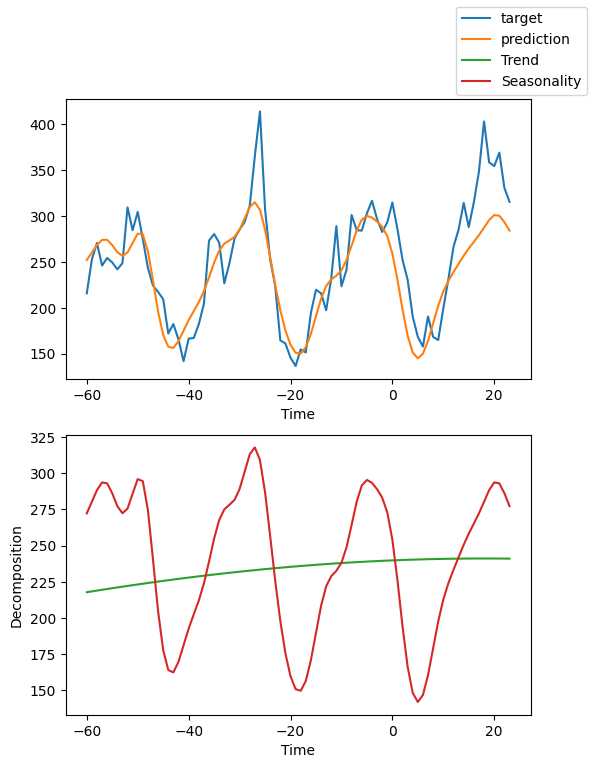

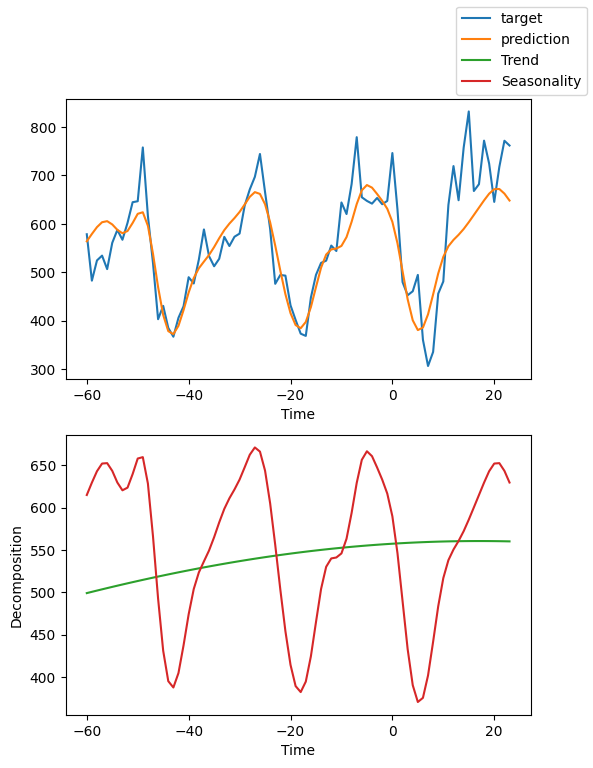

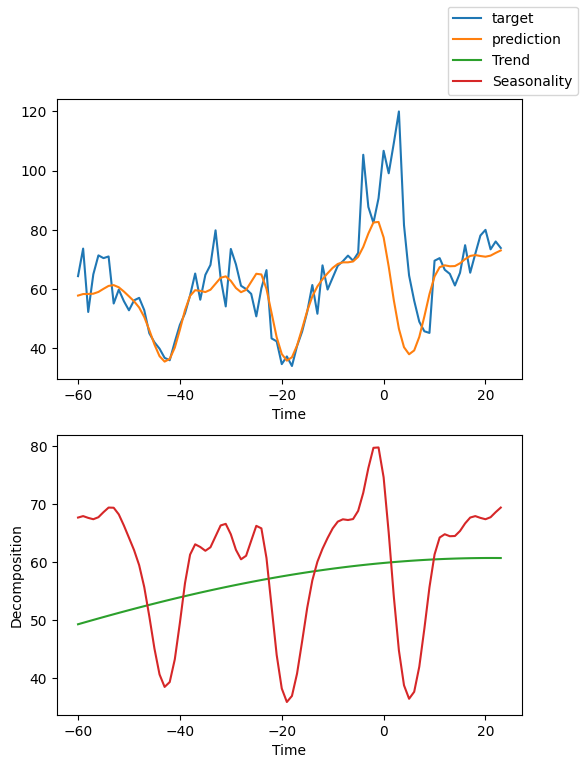

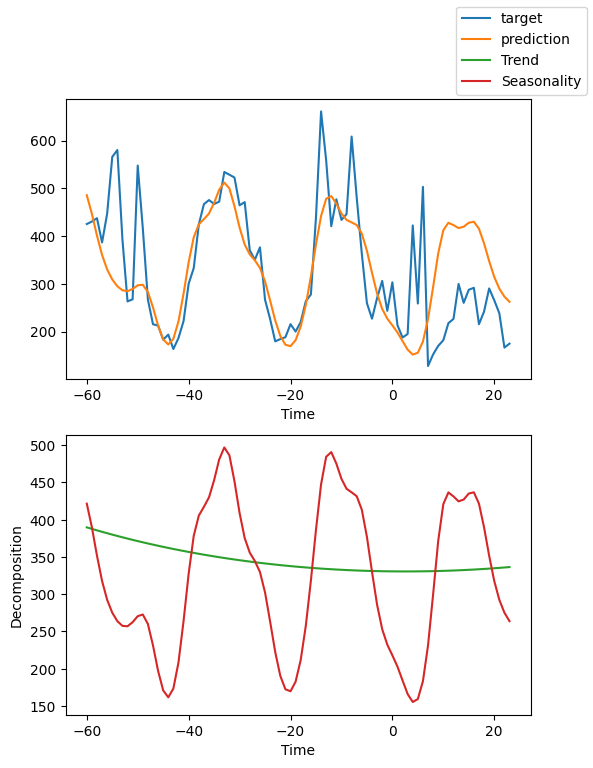

In [ ]:
raw_predictions = net.predict(test_loader, mode="raw", return_x=True)

x = raw_predictions[1]
output = raw_predictions[0]

for idx in range(10,20):  # plot 10 examples
    best_model.plot_interpretation(x, output, idx=idx)